# **Journey to Springfield**
<p style="background:black">
<code style="background:black;color:white">Ivan_Romadin_269011839
</code>
</p>

В этом ноутбуке по большей части была использована структура, предложенная в [бейзлайне](https://drive.google.com/file/d/1-M-yOZ8hIcZQc4os1HMGJ11ij3BKy7Nj/view?usp=sharing), но пересобранная и модифицированная под себя.  

Я начал с простого AlexNet-a, смог его прокачать до ~0.96 на лидерборде с помощью аугментации, шедулера и большого батча, а затем вспомил цитату Andrej Karpathy "Don't be a hero!" и загрузил EfficientNet, который cходу выдал топовый результат.  

Я фиксирую свой прогресс и сохранял промежуточные ноутбуки на [страничке в Notion](https://wanomir.notion.site/b042c70d49de4ddf9d5aff7d2514dadb?v=a8d0058dd2bf49c189bf0683e22688b7) (*нажать на кат "hidden groups"*), мне кажется неплохая структура вышла для работы над будущими проектами и соревнованиями.

***
## Setup

### Libraries and settings

#### Basic

In [95]:
# basic libraries
import math
import os
import random
import re
import time
import warnings

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output, display
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_notebook

# plt.style.use("dark_background")
# sns.set_palette("deep")
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (8, 4)
%config InlineBackend.figure_format = "retina"
%matplotlib inline
warnings.filterwarnings("ignore")

#### Project specific

In [96]:
!pip install efficientnet_pytorch
clear_output()

In [97]:
# torch
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as tfs
from efficientnet_pytorch import EfficientNet

In [98]:
# sklearn
from skimage import io
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [99]:
# others
import copy
import pickle
from multiprocessing.pool import ThreadPool
from pathlib import Path

import matplotlib.patches as patches
from matplotlib import colors
from matplotlib.font_manager import FontProperties
from PIL import Image

#### Backend settings

In [100]:
DEVICE = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)
DEVICE

device(type='cuda')

In [101]:
DATA_MODES = ["train", "val", "test"]
RESCALE_SIZE = 224

Фиксируем генераторы рандомных чисел для воспроизводимости результатов.

In [102]:
SEED = 2023

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)

### Functions

#### Dataset

Практически все то же что и в бейзлайне, но добавлена аугментация тренировочных изображений. 

In [103]:
class SimpsonsDataset(torch.utils.data.Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != "test":
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open("label_encoder.pkl", "wb") as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):

        if self.mode == "train":
            transform = tfs.Compose(
                [
                    tfs.ToTensor(),
                    tfs.RandomHorizontalFlip(),
                    tfs.RandomVerticalFlip(),
                    tfs.RandomPerspective(),
                    tfs.RandomRotation(30),
                    tfs.RandomAutocontrast(p=0.5),
                    tfs.RandomCrop(RESCALE_SIZE),
                    tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            )
        else:
            transform = tfs.Compose(
                [
                    tfs.ToTensor(),
                    tfs.Resize(RESCALE_SIZE),
                    tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            )
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype="float32")
        x = transform(x)
        if self.mode == "test":
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

#### Training and evaluation

В функцию `fit_epoch` добавлена опция с шедулером.

In [104]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    if scheduler != None:
        scheduler.step()

    running_loss = 0.0
    running_correct = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_correct.cpu().numpy() / processed_data
    return train_loss, train_acc

In [105]:
def eval_epoch(model, val_loader, criterion):

    model.eval()
    running_loss = 0.0
    running_correct = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_correct.cpu().numpy() / processed_size
    return val_loss, val_acc

В функцию `train` добавлен функционал сохранения самой удачной модели и измерения времени затреченного на тренировку.

In [106]:
def train(
    train_files,
    val_files,
    model,
    optimizer,
    scheduler,
    epochs,
    batch_size,
):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_epoch = 0

    start = time.time()
    log_template = "Epoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}\n"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):

            train_loss, train_acc = fit_epoch(
                model, train_loader, criterion, optimizer, scheduler
            )

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(
                log_template.format(
                    ep=epoch + 1,
                    t_loss=train_loss,
                    v_loss=val_loss,
                    t_acc=train_acc,
                    v_acc=val_acc,
                )
            )

            if val_acc > best_acc:
                best_acc = val_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    hms_string(time.time() - start)
    print("Best acc.: {:.4f} on epoch {}".format(best_acc, best_epoch+1))
    return model, history

In [107]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [108]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

#### Plotting

In [109]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    print("\nElapsed in: {}:{:>02}:{:>05.2f}".format(h, m, s))

In [110]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Для чистоты кода и удобства код для отрисовки изображений обернут в функции. Подправлены форматировние текста, лэйблы, общий лэйаут.

In [111]:
def plot_images_grid(dataset, size=3):

    figsize = (2.5 * size, 2.5 * size)
    fig, ax = plt.subplots(
        nrows=size, ncols=size, figsize=figsize, sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, 1000))
        im_val, label = dataset[random_characters]
        img_label = " ".join(
            map(
                lambda x: x.capitalize(),
                val_dataset.label_encoder.inverse_transform([label])[0].split("_"),
            )
        )
        imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
    fig.tight_layout();

In [112]:
def plot_with_preds(dataset, model, size=3):

    figsize = (2.5 * size, 2.5 * size)
    fig, ax = plt.subplots(
        nrows=size, ncols=size, figsize=figsize, sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, 1000))
        im_val, label = val_dataset[random_characters]
        img_label = " ".join(
            map(
                lambda x: x.capitalize(),
                val_dataset.label_encoder.inverse_transform([label])[0].split("_"),
            )
        )

        imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

        actual_text = "Actual : {}".format(img_label)

        fig_x.add_patch(patches.Rectangle((0, -1), 120, 40, color="white"))
        font0 = FontProperties()
        font = font0.copy()
        font.set_family("PT Sans")
        prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
        predicted_proba = np.max(prob_pred) * 100
        y_pred = np.argmax(prob_pred)

        predicted_label = label_encoder.classes_[y_pred]
        predicted_label = (
            predicted_label[: len(predicted_label) // 2]
            + "\n"
            + predicted_label[len(predicted_label) // 2 :]
        )
        predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

        fig_x.text(
            2,
            8,
            predicted_text,
            horizontalalignment="left",
            fontproperties=font,
            verticalalignment="top",
            fontsize=10,
            color="DarkSlateBlue",
            fontweight="bold",
        )

    fig.tight_layout();

### Data loading

In [113]:
TRAIN_DIR = Path("/kaggle/input/journey-springfield/train/simpsons_dataset")
TEST_DIR = Path("/kaggle/input/journey-springfield/testset/testset")

train_val_files = sorted(list(TRAIN_DIR.rglob("*.jpg")))
test_files = sorted(list(TEST_DIR.rglob("*.jpg")))

По неизвестной мне причине, мой десктопный JupyterLab сохранял чекпоинты везде где ему вздумается, поэтому пришлось добавить исключающее правило ниже :)

In [114]:
# somehow jupyter files got into the training directory
# so I have to specificly ask not to use them
train_val_files = [
    file for file in train_val_files if ".ipynb_checkpoints" not in str(file)
]

In [115]:
train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(
    train_val_files, test_size=0.2, stratify=train_val_labels, random_state=SEED
)

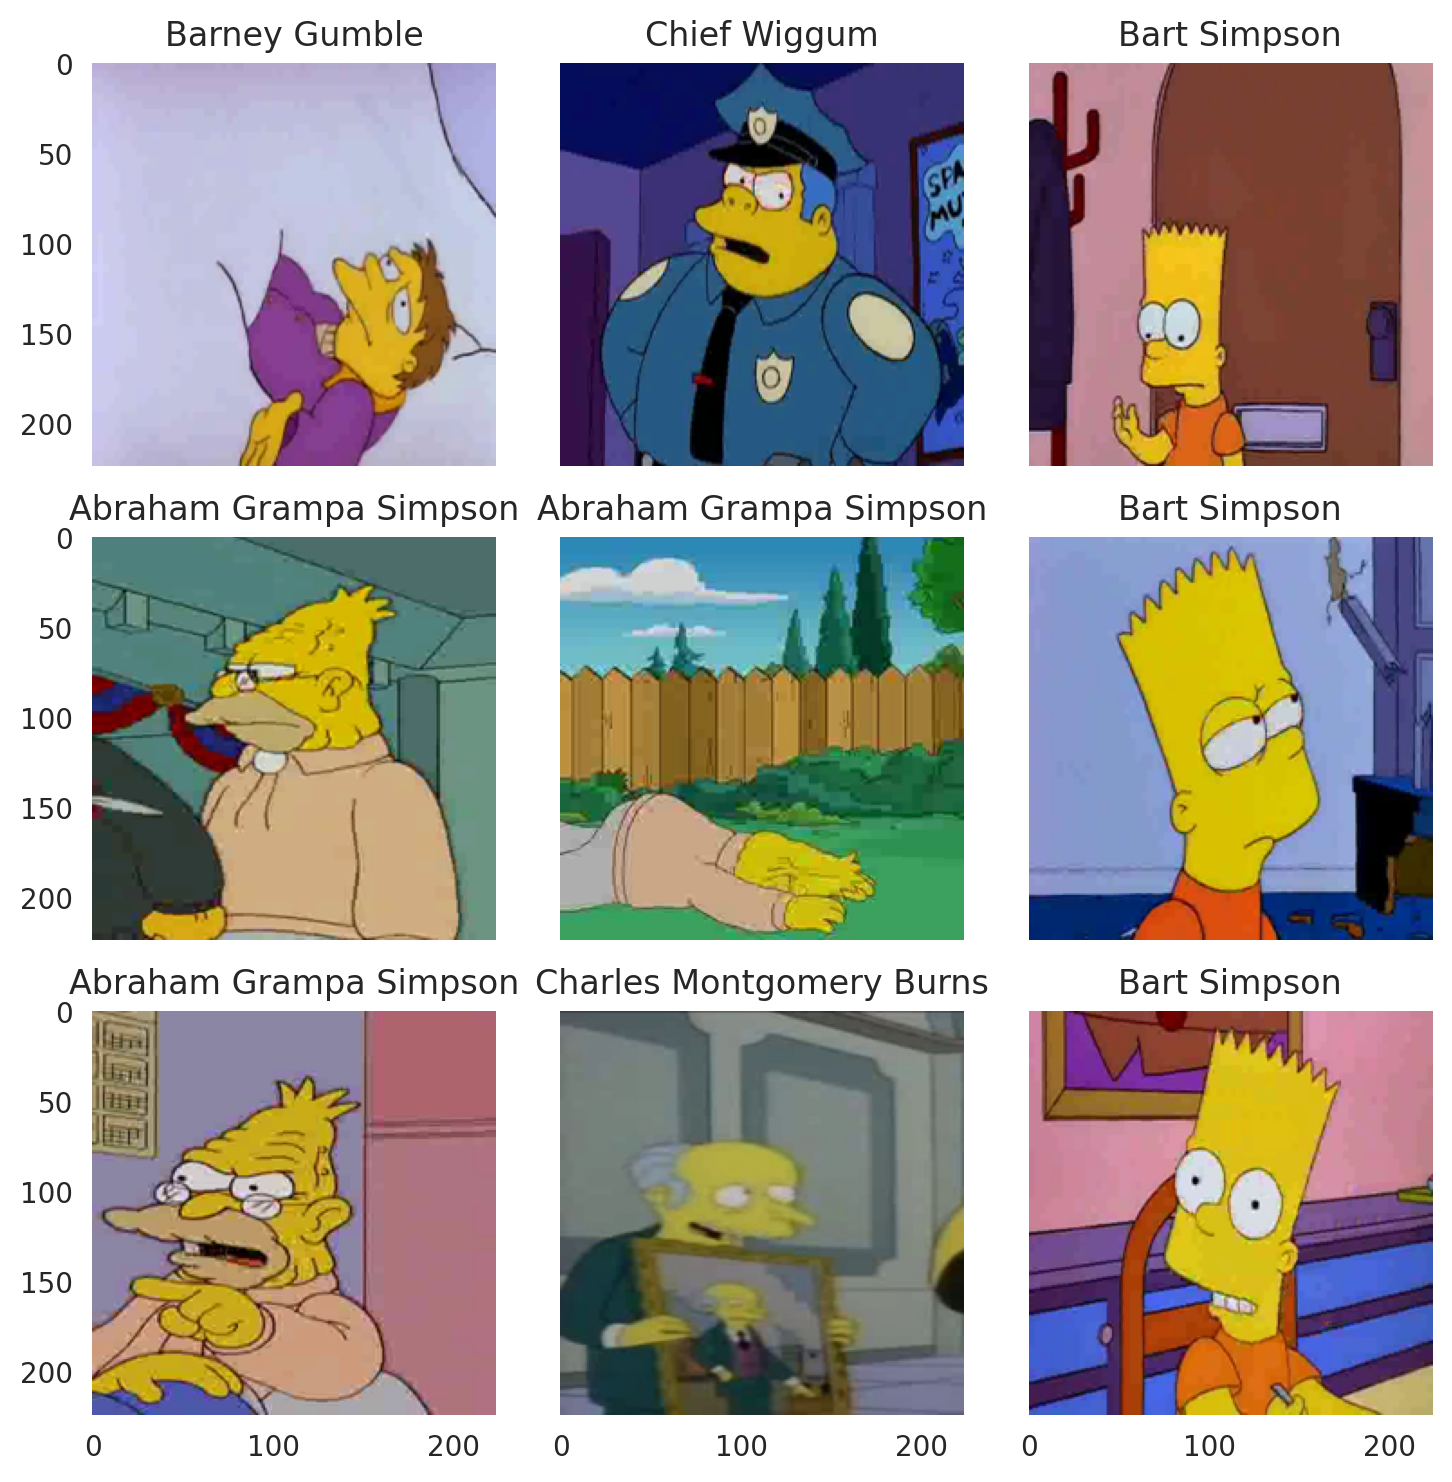

In [116]:
val_dataset = SimpsonsDataset(val_files, mode="val")

plot_images_grid(val_dataset)

***
## Modeling

### Architecture

Берем самый легкий EfficientNet с уже натренированными весами.

In [117]:
model = EfficientNet.from_pretrained("efficientnet-b0")

n_classes = len(np.unique(train_val_labels))
classifier = nn.Linear(in_features=1000, out_features=n_classes)
model.classifier = classifier
model.to(DEVICE)

clear_output()
print("Number of classes: {}".format(n_classes))

Number of classes: 42


### Training

In [118]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode="val")
train_dataset = SimpsonsDataset(train_files, mode="train")

In [119]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

model, history = train(
    train_dataset, val_dataset, model, optimizer, scheduler=scheduler, epochs=20, batch_size=64
)

epoch:   5%|▌         | 1/20 [03:25<1:04:59, 205.26s/it]

Epoch 001 train_loss: 0.8892     val_loss 0.3013 train_acc 0.7991 val_acc 0.9252



epoch:  10%|█         | 2/20 [06:50<1:01:30, 205.01s/it]

Epoch 002 train_loss: 0.2738     val_loss 0.2521 train_acc 0.9260 val_acc 0.9372



epoch:  15%|█▌        | 3/20 [10:15<58:09, 205.25s/it]  

Epoch 003 train_loss: 0.2079     val_loss 0.2144 train_acc 0.9438 val_acc 0.9506



epoch:  20%|██        | 4/20 [13:39<54:33, 204.60s/it]

Epoch 004 train_loss: 0.1586     val_loss 0.2090 train_acc 0.9555 val_acc 0.9508



epoch:  25%|██▌       | 5/20 [17:04<51:12, 204.86s/it]

Epoch 005 train_loss: 0.0849     val_loss 0.1132 train_acc 0.9780 val_acc 0.9790



epoch:  30%|███       | 6/20 [20:29<47:47, 204.79s/it]

Epoch 006 train_loss: 0.0592     val_loss 0.1081 train_acc 0.9838 val_acc 0.9795



epoch:  35%|███▌      | 7/20 [23:53<44:19, 204.57s/it]

Epoch 007 train_loss: 0.0427     val_loss 0.1096 train_acc 0.9881 val_acc 0.9785



epoch:  40%|████      | 8/20 [27:17<40:53, 204.42s/it]

Epoch 008 train_loss: 0.0344     val_loss 0.1091 train_acc 0.9907 val_acc 0.9802



epoch:  45%|████▌     | 9/20 [30:41<37:28, 204.45s/it]

Epoch 009 train_loss: 0.0306     val_loss 0.1175 train_acc 0.9918 val_acc 0.9797



epoch:  50%|█████     | 10/20 [34:07<34:07, 204.74s/it]

Epoch 010 train_loss: 0.0278     val_loss 0.1086 train_acc 0.9919 val_acc 0.9811



epoch:  55%|█████▌    | 11/20 [37:34<30:48, 205.34s/it]

Epoch 011 train_loss: 0.0214     val_loss 0.1057 train_acc 0.9939 val_acc 0.9814



epoch:  60%|██████    | 12/20 [41:02<27:29, 206.22s/it]

Epoch 012 train_loss: 0.0215     val_loss 0.1041 train_acc 0.9942 val_acc 0.9818



epoch:  70%|███████   | 14/20 [47:52<20:33, 205.53s/it]

Epoch 014 train_loss: 0.0190     val_loss 0.1033 train_acc 0.9944 val_acc 0.9809



epoch:  75%|███████▌  | 15/20 [51:16<17:04, 204.99s/it]

Epoch 015 train_loss: 0.0178     val_loss 0.1031 train_acc 0.9952 val_acc 0.9816



epoch:  80%|████████  | 16/20 [54:39<13:38, 204.63s/it]

Epoch 016 train_loss: 0.0169     val_loss 0.1035 train_acc 0.9949 val_acc 0.9818



epoch:  85%|████████▌ | 17/20 [58:04<10:13, 204.49s/it]

Epoch 017 train_loss: 0.0182     val_loss 0.1028 train_acc 0.9944 val_acc 0.9816



epoch:  90%|█████████ | 18/20 [1:01:28<06:49, 204.57s/it]

Epoch 018 train_loss: 0.0156     val_loss 0.1029 train_acc 0.9958 val_acc 0.9818



epoch:  95%|█████████▌| 19/20 [1:04:53<03:24, 204.47s/it]

Epoch 019 train_loss: 0.0155     val_loss 0.1025 train_acc 0.9956 val_acc 0.9823



epoch: 100%|██████████| 20/20 [1:08:18<00:00, 204.91s/it]

Epoch 020 train_loss: 0.0167     val_loss 0.1023 train_acc 0.9954 val_acc 0.9826


Elapsed in: 1:08:18.15
Best acc.: 0.9826 on epoch 20


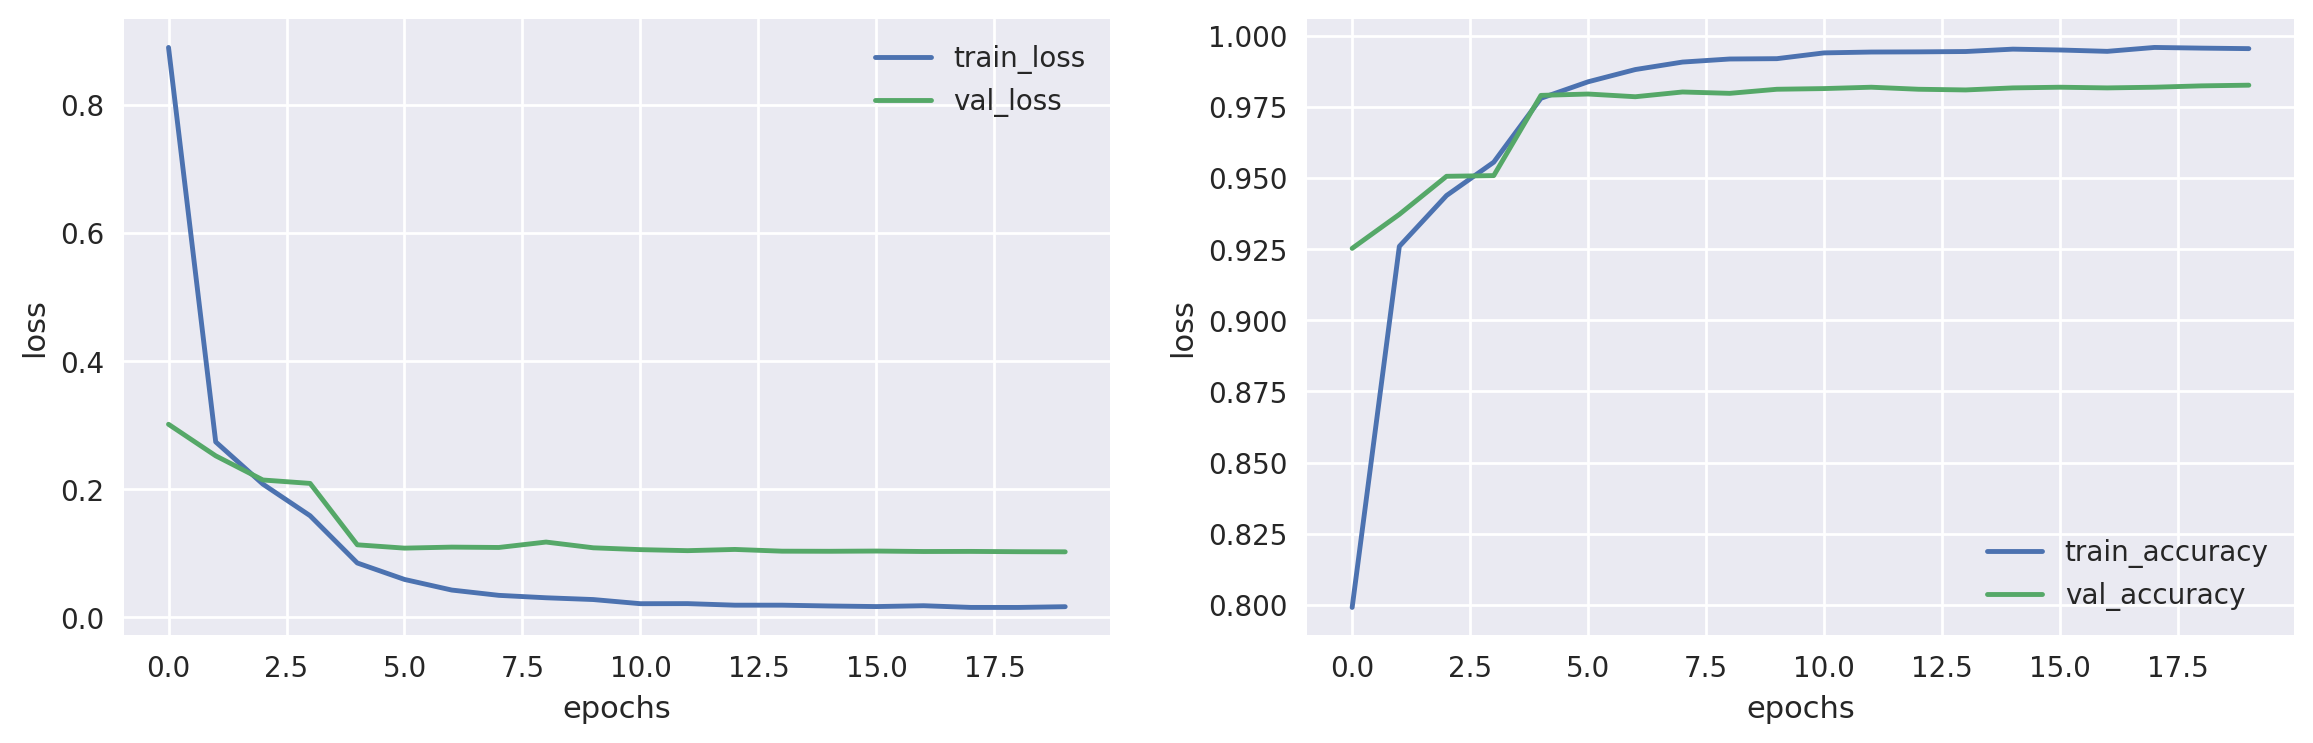

In [120]:
train_loss, train_acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(122)
plt.plot(train_acc, label="train_accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

Как видим, модель уже на 10-й эпохе практически подобралась к идеальному описанию тренировочного  сета и дальше пошла битва за проценты. Можно было попробовать дополнительные методы регуляризации чтобы добиться полной сходимсоти... но лучшее — враг хорошего. Скор и так уже приличный, можно двигаться дальше.

### Evaluation

#### Show predictions

In [121]:
label_encoder = pickle.load(open("label_encoder.pkl", "rb"))

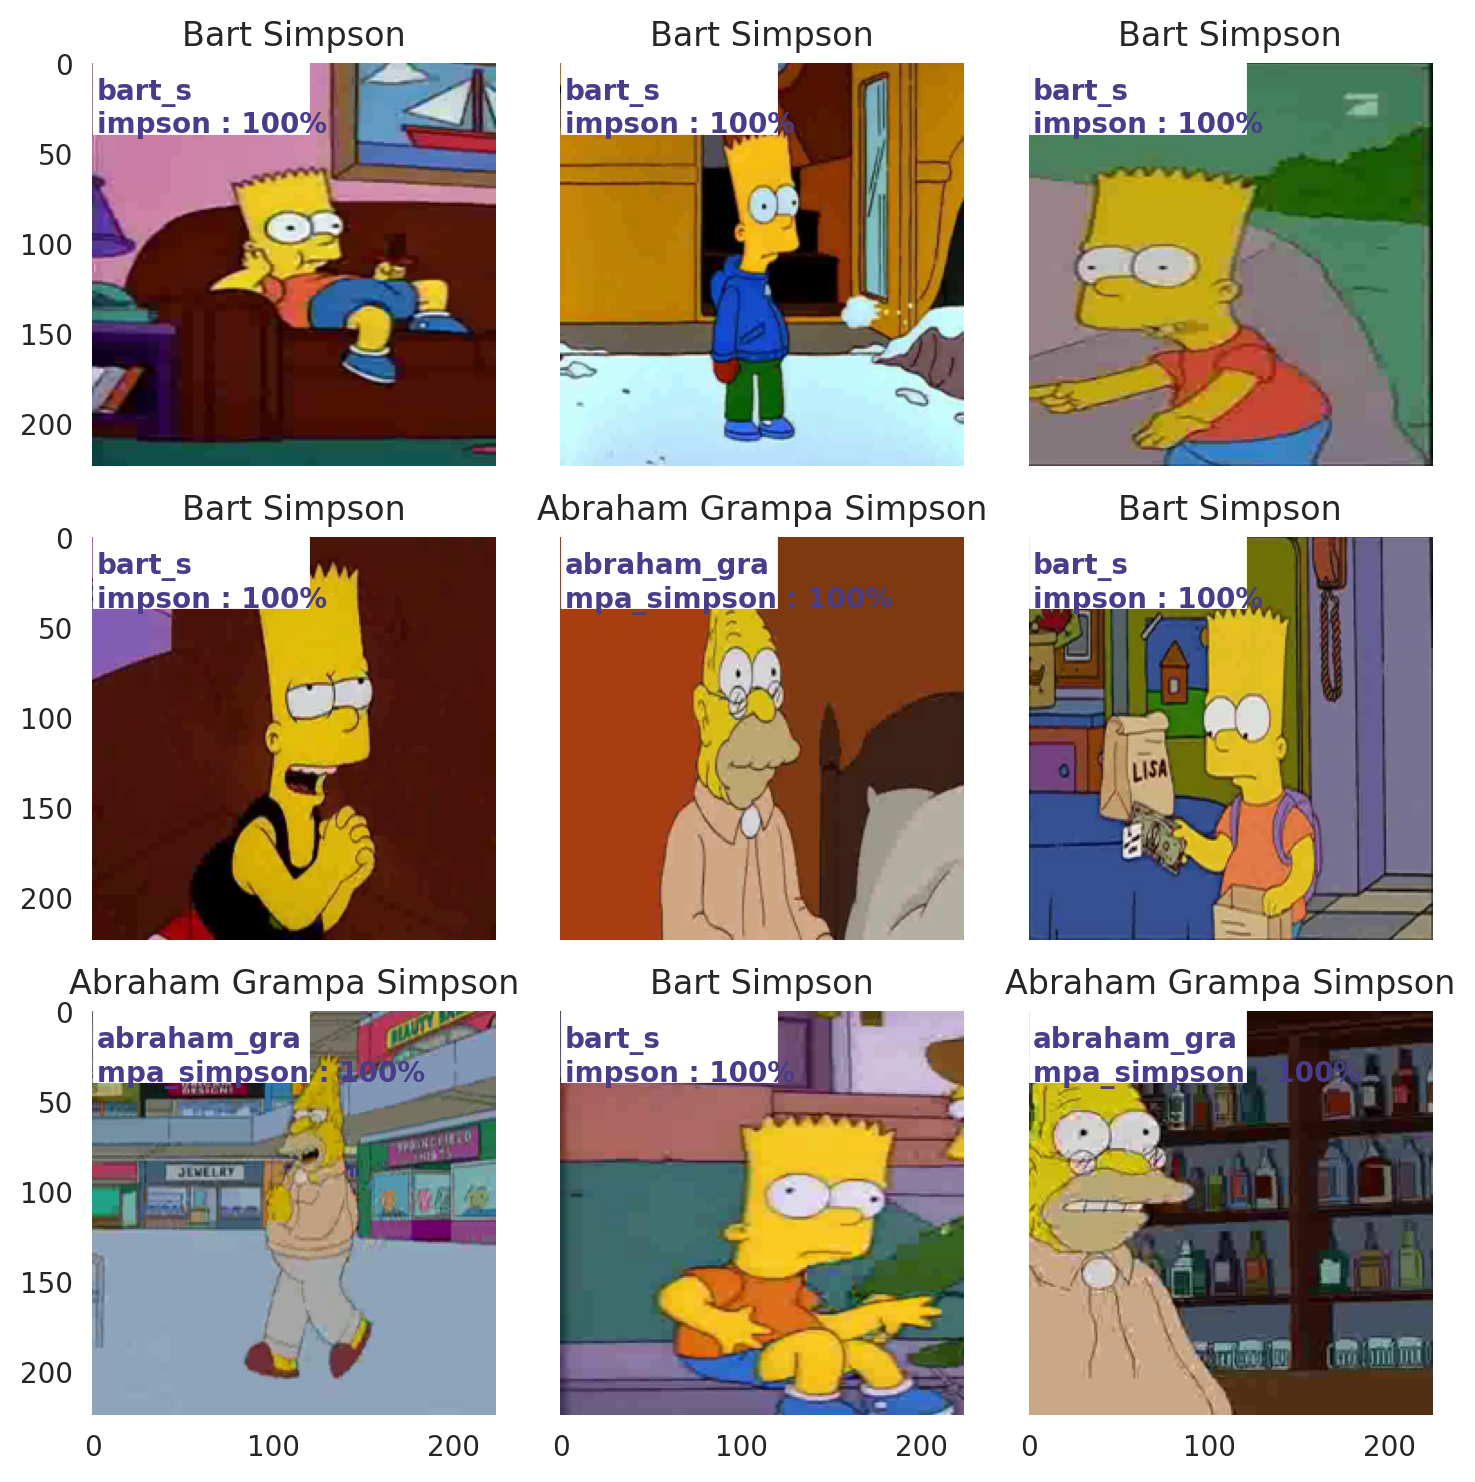

In [122]:
plot_with_preds(val_dataset, model)

Как видим все картинки предсказаны верно.

#### F1 score

In [123]:
sample_size = 500
idx_range = len(val_dataset)

idxs = list(map(int, np.random.randint(0, idx_range, sample_size)))
imgs = [val_dataset[i][0].unsqueeze(0) for i in idxs]
probs_ims = predict(model, imgs)

y_pred = np.argmax(probs_ims, -1)
actual_labels = [val_dataset[i][1] for i in idxs]

In [124]:
f1_score(actual_labels, y_pred, average="micro")

0.982

$F1$ скор совпадает с $accuracy$ на валидационной выборке. Схораняем файл и отправляем на submission.

### Submission

In [125]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [126]:
my_submit = pd.DataFrame({"Id": test_filenames, "Expected": preds})
display(my_submit)
my_submit.to_csv("efficientnet_perfection3.csv", index=False)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum
